# QAOA Algorithm for Constrained Optimization: Knapsack Problem

The following demonstration will show how to use Classiq for optimizing combinatorial optimization problems with constraints, using the QAOA algotrithm [[1](#QAOA)]. The main point is how to combine digital and analog quantum operations for such problems. The specific problem to optimize will be the knapsack problem [[2](#knapsack)]
If you are not familiar with the QAOA algorithm, take a look at the [maxCut demo TODO].

## Introduction

### The Knapsack Problem
Given a set of items, determine how many items to put in the knapsack to maximize their summed value.

* **Input:**
  - Items: A set of item types counts $x_i$, where each $x_i \in [0, d_i]$ .
  - Weights: A set of item weights, denoted as $w_i$.
  - Values: A set of item values, denoted as $v_i$.
  - Weight constraint $C$.
 

* **Output:** Item assignment $\overline{x}$ that maximizes the value: $$\max_{x_i \in D} \Sigma_i v_i x_i$$
  subject to a weight constraint: $$\Sigma_i w_i x_i\leq C$$

The knapsack is known to be an NP-complete problem.

### Set a specific problem instance to optimize:

Here we choose a small toy instance:
* 2 item types:
  * $a \in [0, 7]$ with $w_a=2$, $v_a=3$
  * $b \in [0, 3]$ with $w_b=3$, $v_b=5$
* $C=12$
* The optimal solution is $a=3, b=2$

## Algorithm description

In this problem, there are additional constraints on the search space. One way to address it is to add a penalty term for the constraints. Here we take a different approach, and take advantage of the quantum nature of the algorithm. 

A quantum state $|x\rangle$ will hold the optimziation variables. We will use two different transformations on this variable:
1. Objective Phase (analog): a phase rotation in the Z direction according to the objective value, as done in the vanilla QAOA $$|x\rangle \xrightarrow{U_{\text{o}}(\theta)} e^{i\theta f_{\text{obj}}(x)}|x\rangle$$
   The transformation is done easily with the `phase` statement.
   
3. Constraints Predicate (digital): the constraints are verified digitally, with quantum arithmetics $$|x\rangle|0\rangle \xrightarrow{U_{\text{c}}(\theta)} |x\rangle|c(x)\rangle$$
   The transformation is done with the numeric assignment transformation, such as `assign` (`|=`).

The transformations are combined in the following manner; For each QAOA cost layer, the objective phase transformation is applied conditioned on the constraints predicate value, such that effectively each infeasible solution will be given a 0 phase.

This way we can bypass the need to choose a penalty constant, on the expense of additional arithmetic gates for each layer. Notice that the method as we presented here is relevant for positive maximization problems.

## Algorithm Implementation using Classiq

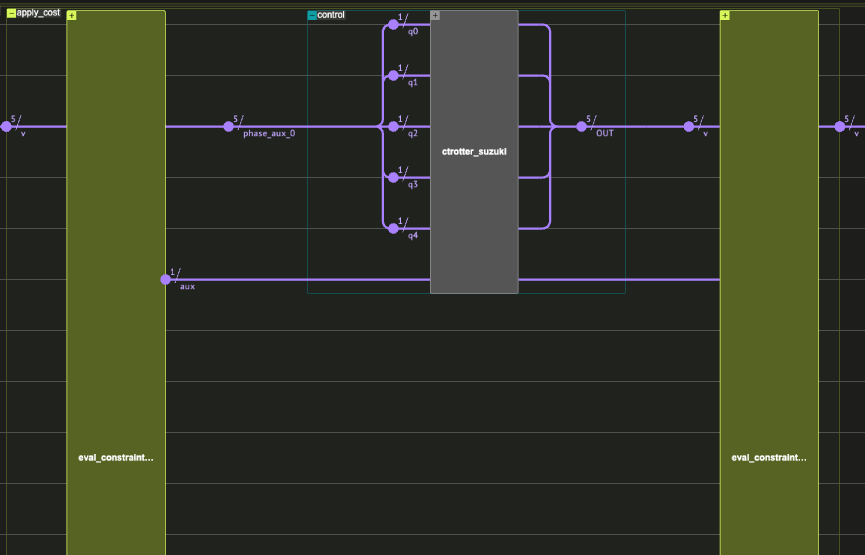

### Define the knapsack problem

A `QStruct` is used to represent the state of optimization variables. The `objective` and `constraint` functions will be used both quantumly, and classicaly in the post-processing.

Notice that the optimization variable are defined as unsigned integers, with the `QNum` type.

In [10]:
from classiq import *


class KnapsackVars(QStruct):
    a: QNum[3]
    b: QNum[2]


def objective(v: KnapsackVars):
    return v.a * 3 + v.b * 5


def constraint(v: KnapsackVars):
    return v.a * 2 + v.b * 3 <= 12


# assign a negative value to the objective to get maximization
def cost(v: KnapsackVars):
    return -objective(v) if constraint(v) else 0

## Define the digital constraints predicate

Here we just use the classical constraint function, which will be tranlsated to a quantum operation. The result is written to an allocated auxilliary.

In [2]:
@qfunc
def eval_constraint(v: KnapsackVars, aux: Output[QBit]):
    aux |= constraint(v)

## Apply Objective Phase controlled on the Contraint predicate result

We wrap the objective `phase` statement with the constraint predicate, so the allocated auxilliary will be release afterwards.
The effective phase will be:
$$
|x\rangle \xrightarrow{U_{\text{o}}(\theta)} 
\begin{cases}
e^{i\theta f_{\text{obj}}(x)} |x\rangle & \text{if } \text{constraint}(x) = 1, \\
|x\rangle & \text{if } \text{constraint}(x) = 0.
\end{cases}
$$

In [3]:
@qfunc
def apply_cost(gamma: CReal, v: KnapsackVars) -> None:
    aux = QBit("aux")
    within_apply(  # Rotate states per their objective value, if they satisfy the constraint
        within=lambda: eval_constraint(v, aux),
        apply=lambda: control(aux, lambda: phase(-objective(v), gamma)),
    )

## Assemble to the full QAOA algorithm

As in the vanilla QAOA, the cost and mixer layers are applied sequentially with varying parameters, that will be set by the classical optimization loop:

In [4]:
NUM_LAYERS = 3


@qfunc
def main(params: CArray[CReal, NUM_LAYERS * 2], v: Output[KnapsackVars]):
    allocate(v.size, v)
    hadamard_transform(v)
    repeat(
        NUM_LAYERS,
        lambda i: [
            apply_cost(params[2 * i], v),
            apply_to_all(lambda q: RX(params[2 * i + 1], q), v),  # mixer layer
        ],
    )


qmod = create_model(main)
write_qmod(qmod, "qaoa_knapsack")
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/a5c62332-49aa-42a9-9ceb-7681eb0036f2?version=0.62.0


## Classical Optimization

Now we have a parameteric circuit, that we can sample by providing it the expected parameters, which are an array of size `NUM_LAYERS*2`.
The `ExecutionSession` object is used in order to execute the circuit with given pararmeters. the method `ExecutionSession.estimate_cost` should be provided with the execution parameters and a `cost_func` for evaluating the cost of a given sample. Notice that the same `objective` function that was use in the quantum `phase` application is used here in the classical post-processing.

For the classical optimizer we use `scipy.optimize.minimize` with the `COBYLA` optimization method, that will be called with the `evaluate_params` function.

Optimization Progress: 61it [10:08,  9.97s/it]                                                                                                                                                                                                     

Optimized parameters: [0.9649326851203814, -0.23165924563160517, 0.0074804482882825435, -0.3747878673787718, -0.12849067421962063, -0.07711635030658603]


Text(0.5, 1.0, 'Cost convergence')

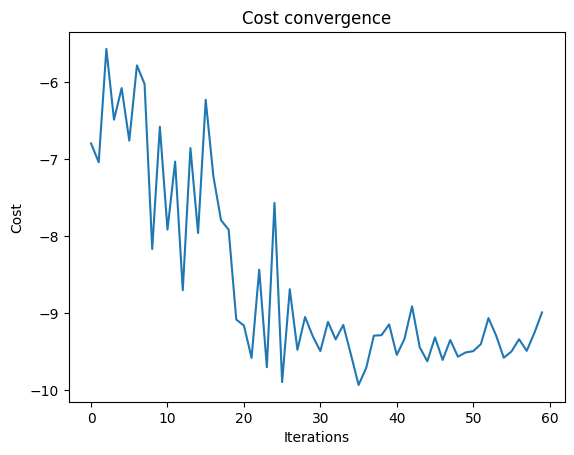

In [12]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

from classiq.execution import *

NUM_SHOTS = 1000
MAX_ITERATIONS = 60

# start with a linear scheduling guess
initial_params = (
    np.concatenate((np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS)))
    * math.pi
)

cost_trace = []


def evaluate_params(params):
    cost_estimation = es.estimate_cost(
        cost_func=lambda state: cost(state["v"]), parameters={"params": params.tolist()}
    )
    cost_trace.append(cost_estimation)
    return cost_estimation


with ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
) as es:
    with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

        def progress_bar(xk: np.ndarray) -> None:
            pbar.update(1)  # increment progress bar

        final_params = scipy.optimize.minimize(
            fun=evaluate_params,
            x0=initial_params,
            method="COBYLA",
            options={"maxiter": MAX_ITERATIONS},
            callback=progress_bar,
        ).x.tolist()

print(f"Optimized parameters: {final_params}")
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

After the optimization, we sample the the circuit with the optimized parameters:

In [13]:
with ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
) as es:
    res = es.sample({"params": final_params})

Print the resulting solutions according to the probability:

In [9]:
sorted_counts = sorted(res.parsed_counts, key=lambda sampled: cost(sampled.state["v"]))
for sampled in sorted_counts:
    v = sampled.state["v"]
    print(
        f"solution={v} probability={sampled.shots/NUM_SHOTS} objective={objective(v)} constraint={constraint(v)}"
    )

solution={'a': 3, 'b': 2} probability=0.026 objective=19 constraint=True
solution={'a': 1, 'b': 3} probability=0.036 objective=18 constraint=True
solution={'a': 6, 'b': 0} probability=0.03 objective=18 constraint=True
solution={'a': 4, 'b': 1} probability=0.038 objective=17 constraint=True
solution={'a': 2, 'b': 2} probability=0.035 objective=16 constraint=True
solution={'a': 0, 'b': 3} probability=0.032 objective=15 constraint=True
solution={'a': 5, 'b': 0} probability=0.027 objective=15 constraint=True
solution={'a': 3, 'b': 1} probability=0.033 objective=14 constraint=True
solution={'a': 1, 'b': 2} probability=0.022 objective=13 constraint=True
solution={'a': 4, 'b': 0} probability=0.035 objective=12 constraint=True
solution={'a': 2, 'b': 1} probability=0.022 objective=11 constraint=True
solution={'a': 0, 'b': 2} probability=0.036 objective=10 constraint=True
solution={'a': 3, 'b': 0} probability=0.037 objective=9 constraint=True
solution={'a': 1, 'b': 1} probability=0.032 objective

## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='knapsack'>[2]</a>: [Knapsack problem (Wikipedia)](https://en.wikipedia.org/wiki/Knapsack_problem)